In [103]:
# %% Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

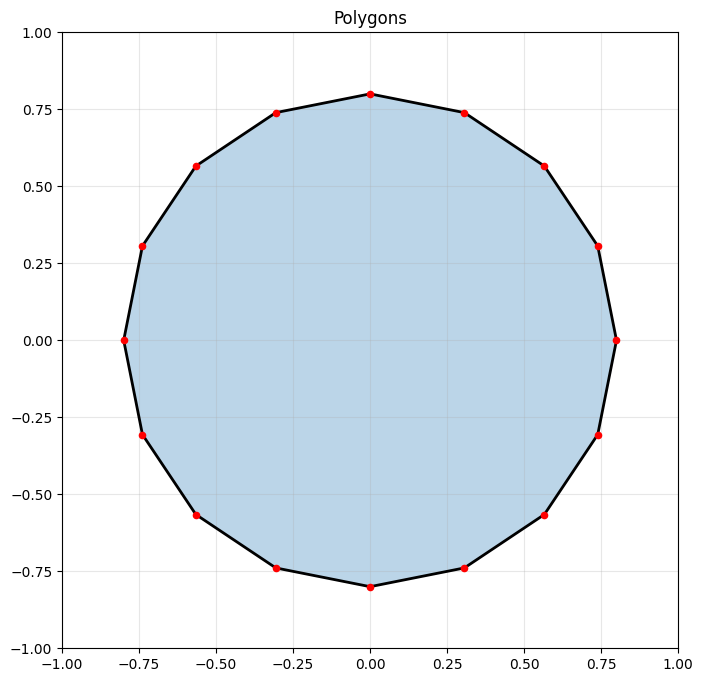

In [104]:
from ainr import generate_polygons, plot_polygons


# , stretch=(1, 0.5), star_ratio=0.9, rotation=[np.pi/4, -np.pi/3, np.pi/5]
polygons = generate_polygons('1x16', convex=True)
plot_polygons(polygons)

In [105]:
def robust_pca(vertices: np.ndarray):
    """
    Compute robust PCA with deterministic orientation.
    Works for any dimension (2D, 3D, etc.).
    
    Args:
        vertices: (N, D) array of points
    
    Returns:
        center: (D,) centroid
        axes: (D, D) principal axes (rows are axes, sorted by variance)
        eigenvalues: (D,) variances along each axis
    """
    center = vertices.mean(axis=0)
    centered = vertices - center
    n_dims = vertices.shape[1]
    
    # Covariance
    cov = centered.T @ centered / len(vertices)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort descending by variance
    order = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[order]
    axes = eigenvectors[:, order].T.copy()
    
    # Near-equal variance: prefer coordinate-alignment for most dominant axis
    # (Only check first two axes if they exist)
    if n_dims >= 2 and eigenvalues[0] > 1e-10:
        ratio = eigenvalues[1] / eigenvalues[0]
        if ratio > 0.99:
            # Swap if second axis is more aligned with first coordinate
            if abs(axes[1, 0]) > abs(axes[0, 0]):
                axes[[0, 1]] = axes[[1, 0]]
                eigenvalues[[0, 1]] = eigenvalues[[1, 0]]
    
    # Deterministic sign: point towards where more mass lies
    # Fallback to positive coordinate direction if mass is nearly balanced
    for i in range(n_dims):
        # Project centered points onto this axis
        projections = centered @ axes[i]
        mass_sum = projections.sum()
        
        # If mass is nearly balanced (within 10% of total spread)
        mass_threshold = 0.1 * np.abs(projections).sum()
        
        if abs(mass_sum) < mass_threshold:
            # Fallback: prefer positive direction along first non-zero coordinate
            for dim in range(n_dims):
                if abs(axes[i, dim]) > 1e-10:
                    if axes[i, dim] < 0:
                        axes[i] *= -1
                    break
        else:
            # Use mass-based direction
            if mass_sum < 0:
                axes[i] *= -1
    
    return center, axes, eigenvalues

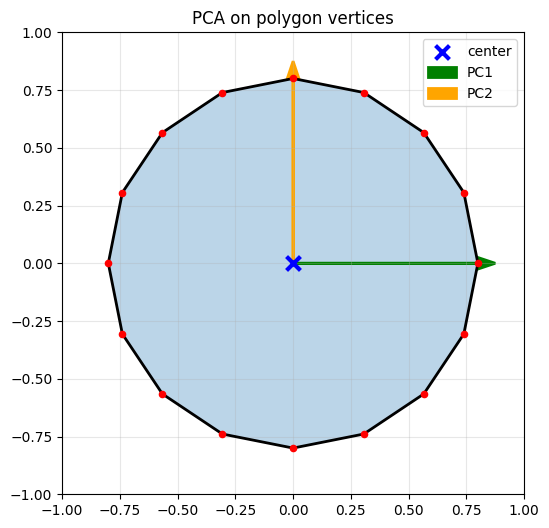

In [106]:
vertices = np.concatenate(polygons, axis=0)
center, axes, variances = robust_pca(vertices)

# Visualize
plt.figure(figsize=(6, 6))

# Draw each polygon with fill and outline (like plot_polygons)
colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
for i, polygon in enumerate(polygons):
    # Close polygon by adding first vertex at end
    closed_poly = np.vstack([polygon, polygon[0:1]])
    plt.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=2)
    plt.fill(closed_poly[:, 0], closed_poly[:, 1], color=colors[i], alpha=0.3)

# Mark all vertices
plt.scatter(vertices[:, 0], vertices[:, 1], c='red', s=20, zorder=5)

# Draw center
plt.scatter(*center, c='blue', s=100, marker='x', lw=3, zorder=10, label='center')

# Draw PCA axes
for i, (ax, col) in enumerate(zip(axes, ['green', 'orange'])):
    plt.arrow(center[0], center[1], ax[0]*0.8, ax[1]*0.8, 
              head_width=0.05, color=col, lw=2, label=f'PC{i+1}')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('PCA on polygon vertices')
plt.show()

In [107]:
def clip_line(origin, direction, halfspace_normals=None, halfspace_points=None, box_min=-1, box_max=1):
    """Clip line to region, return (t_min, t_max) or (None, None)."""
    direction = direction / np.linalg.norm(direction)
    t_min, t_max = -np.inf, np.inf
    
    # Clip to box
    for i in range(2):
        if abs(direction[i]) > 1e-12:
            t1 = (box_min - origin[i]) / direction[i]
            t2 = (box_max - origin[i]) / direction[i]
            t_min = max(t_min, min(t1, t2))
            t_max = min(t_max, max(t1, t2))
        elif origin[i] < box_min or origin[i] > box_max:
            return None, None
    
    # Clip to half-spaces
    if halfspace_normals is not None:
        for normal, point in zip(halfspace_normals, halfspace_points):
            d_dot_n = np.dot(direction, normal)
            if abs(d_dot_n) > 1e-12:
                t_boundary = np.dot(point - origin, normal) / d_dot_n
                if d_dot_n > 0:
                    t_min = max(t_min, t_boundary)
                else:
                    t_max = min(t_max, t_boundary)
            elif np.dot(point - origin, normal) < 0:
                return None, None
    
    return (t_min, t_max) if t_min <= t_max else (None, None)


def build_hierarchical_pca(vertices, max_depth=2, box_min=-1, box_max=1, 
                           halfspace_normals=None, halfspace_points=None):
    """
    Build hierarchical PCA. Returns dict: {'pc1': (p_start, p_end), 'pc2': (p_start, p_end), '++': {...}, ...}
    
    halfspace_normals/halfspace_points: accumulated constraints from ALL parent levels
    """
    if len(vertices) < 3:
        return None
    
    center, axes, variances = robust_pca(vertices)
    
    # Create line segments for PC1 and PC2
    lines = {}
    for i, pc_key in enumerate(['pc1', 'pc2']):
        t_range = clip_line(center, axes[i], halfspace_normals, halfspace_points, box_min, box_max)
        if t_range[0] is not None:
            direction = axes[i] / np.linalg.norm(axes[i])
            p_start = center + t_range[0] * direction
            p_end = center + t_range[1] * direction
            lines[pc_key] = (p_start, p_end)
    
    node = {'center': center, 'axes': axes, 'variances': variances, **lines}
    
    # Recurse into quadrants
    if max_depth > 0:
        proj = (vertices - center) @ axes.T
        for s1, s2, key in [(1, 1, '++'), (1, -1, '+-'), (-1, -1, '--'), (-1, 1, '-+')]:
            mask = ((np.sign(proj[:, 0]) == s1) | (proj[:, 0] == 0)) & \
                   ((np.sign(proj[:, 1]) == s2) | (proj[:, 1] == 0))
            
            # Accumulate half-spaces: add current level's constraints to existing ones
            new_normals = list(halfspace_normals) if halfspace_normals else []
            new_points = list(halfspace_points) if halfspace_points else []
            new_normals.extend([s1 * axes[0], s2 * axes[1]])
            new_points.extend([center, center])
            
            child = build_hierarchical_pca(vertices[mask], max_depth - 1, box_min, box_max,
                                          new_normals, new_points)
            if child is not None:
                node[key] = child
    
    return node

hierarchy = build_hierarchical_pca(vertices, max_depth=1)

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def compute_sdf_sampling(p_start, p_end, polygons, n_samples=1000):
    """Compute SDF along line segment."""
    # Sample line
    t = np.linspace(0, 1, n_samples)
    points = p_start + t[:, None] * (p_end - p_start)
    
    # Sample polygon edges (50 points per edge)
    poly_samples = []
    for poly in polygons:
        for i in range(len(poly)):
            v1, v2 = poly[i], poly[(i + 1) % len(poly)]
            poly_samples.append(v1 + np.linspace(0, 1, 100, endpoint=False)[:, None] * (v2 - v1))
    poly_samples = np.vstack(poly_samples)
    
    # Find nearest distances using KD-tree
    distances = KDTree(poly_samples).query(points)[0]
    
    # Vectorized inside/outside check (ray casting)
    inside = np.zeros(len(points), dtype=bool)
    for poly in polygons:
        v = np.asarray(poly)
        v_next = np.roll(v, -1, axis=0)
        
        # Check ray crossings for all points at once
        py = points[:, 1:2]  # Shape (N, 1)
        v_y, v_next_y = v[:, 1], v_next[:, 1]
        
        # Edges that potentially cross the ray
        crosses = ((v_y <= py) & (py < v_next_y)) | ((v_next_y <= py) & (py < v_y))
        
        # Compute x-intersections
        t_cross = (py - v_y) / (v_next_y - v_y + 1e-10)
        x_cross = v[:, 0] + t_cross * (v_next[:, 0] - v[:, 0])
        
        # Count crossings to the right of each point
        inside |= (np.sum(crosses & (x_cross > points[:, 0:1]), axis=1) % 2 == 1)
    
    return t, np.where(inside, -distances, distances)

def extract_all_lines(node, depth=0, path='', result=None):
    """Recursively extract all (p_start, p_end) tuples with labels."""
    if result is None:
        result = []
    if node is None:
        return result
    
    for pc in ['pc1', 'pc2']:
        if pc in node:
            label = f"D{depth}: {path}{pc}" if path else f"D{depth}: {pc}"
            result.append((node[pc], label))
    
    for quad in ['++', '+-', '--', '-+']:
        if quad in node:
            extract_all_lines(node[quad], depth + 1, f"{path}{quad}/", result)
    
    return result

# Get all lines
all_lines_data = extract_all_lines(hierarchy)
line_segments = [line for line, _ in all_lines_data]
labels = [label for _, label in all_lines_data]

In [109]:
import numpy as np

def simplify_sdf_to_knots(t_values, sdf_values, tolerance=0.005):
    """Simplify SDF to knots using Douglas-Peucker algorithm."""
    
    def perpendicular_distance(point_idx, start_idx, end_idx):
        x0, y0 = t_values[point_idx], sdf_values[point_idx]
        x1, y1 = t_values[start_idx], sdf_values[start_idx]
        x2, y2 = t_values[end_idx], sdf_values[end_idx]
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            return np.sqrt((x0 - x1)**2 + (y0 - y1)**2)
        return abs(dy * x0 - dx * y0 + x2 * y1 - y2 * x1) / np.sqrt(dx**2 + dy**2)
    
    def douglas_peucker(start_idx, end_idx):
        max_dist, max_idx = 0, start_idx
        for i in range(start_idx + 1, end_idx):
            dist = perpendicular_distance(i, start_idx, end_idx)
            if dist > max_dist:
                max_dist, max_idx = dist, i
        
        if max_dist > tolerance:
            left = douglas_peucker(start_idx, max_idx)
            right = douglas_peucker(max_idx, end_idx)
            return left + right[1:]
        return [start_idx, end_idx]
    
    # Douglas-Peucker
    keep = sorted(set(douglas_peucker(0, len(t_values) - 1)))
    
    knot_t, knot_sdf = t_values[keep], sdf_values[keep]
    
    # Compute error
    sdf_interp = np.interp(t_values, knot_t, knot_sdf)
    max_error = np.max(np.abs(sdf_values - sdf_interp))
    mean_error = np.mean(np.abs(sdf_values - sdf_interp))
    
    return knot_t, knot_sdf, max_error, mean_error


# Compute knots for all lines from previous cell
print(f"Computing knots for {len(line_segments)} lines...")
all_knots = []

for (p_start, p_end), label in zip(line_segments, labels):
    t, sdf = compute_sdf_sampling(p_start, p_end, polygons, n_samples=1000)
    knot_t, knot_sdf, max_err, mean_err = simplify_sdf_to_knots(t, sdf, tolerance=0.005)
    
    depth = int(label.split(':')[0].replace('D', '')) if 'D' in label else 0
    pc_type = 'pc1' if 'pc1' in label else 'pc2'
    
    all_knots.append({
        't': t, 'sdf': sdf,
        'knot_t': knot_t, 'knot_sdf': knot_sdf,
        'max_error': max_err, 'mean_error': mean_err,
        'label': label, 'line': (p_start, p_end),
        'depth': depth, 'pc_type': pc_type
    })
    
    print(f"  {label}: {len(knot_t)} knots, max_err={max_err:.6f}")

print("\nDone!")

Computing knots for 10 lines...
  D0: pc1: 3 knots, max_err=0.003594
  D0: pc2: 3 knots, max_err=0.003594
  D1: ++/pc1: 5 knots, max_err=0.001934
  D1: ++/pc2: 2 knots, max_err=0.000000
  D1: +-/pc1: 5 knots, max_err=0.001934
  D1: +-/pc2: 2 knots, max_err=0.000000
  D1: --/pc1: 5 knots, max_err=0.001934
  D1: --/pc2: 2 knots, max_err=0.000000
  D1: -+/pc1: 5 knots, max_err=0.001934
  D1: -+/pc2: 2 knots, max_err=0.000000

Done!


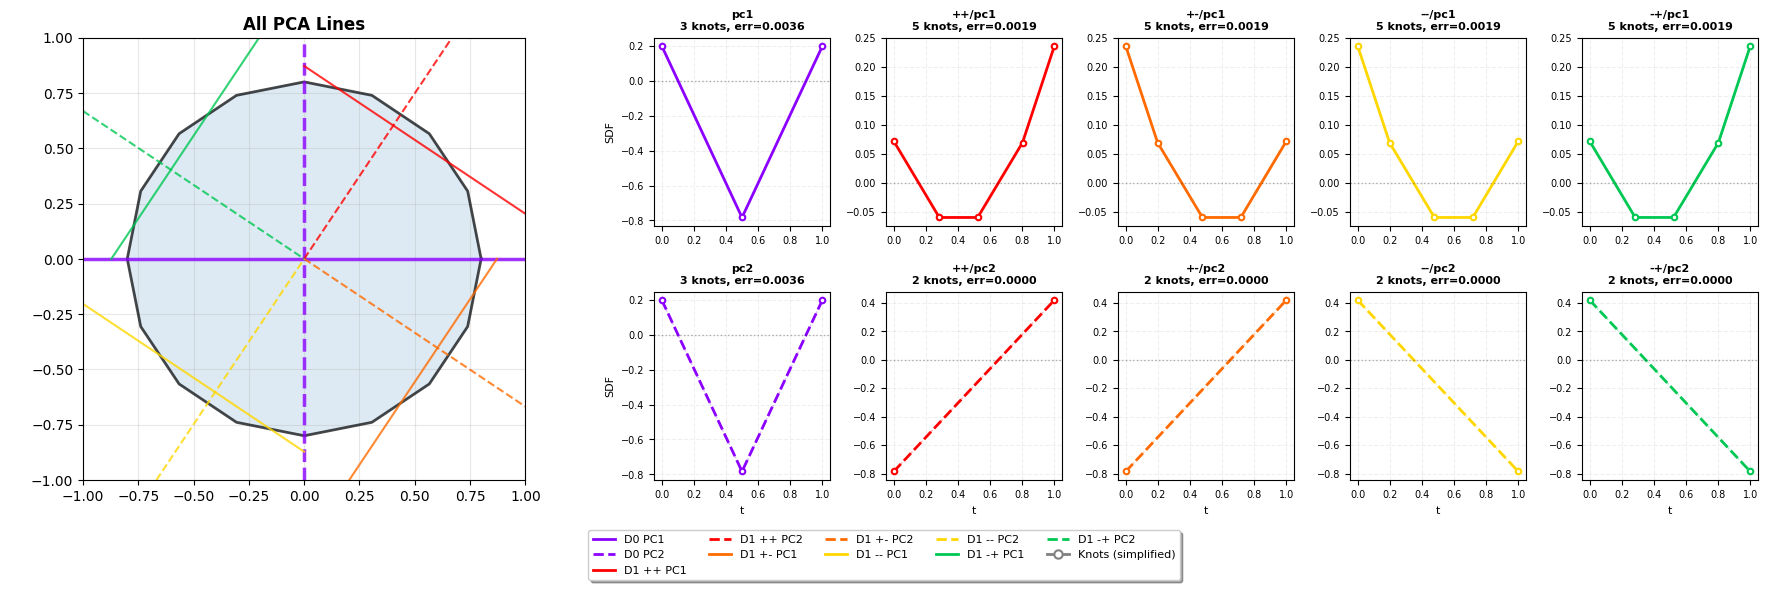

In [110]:
# This function has been moved to ainr/vis.py
# Import it with: from ainr import plot_sdf_with_knots

# Plot everything with knots
from ainr import plot_sdf_with_knots
plot_sdf_with_knots(all_knots, polygons)

In [111]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import matplotlib
from typing import List, Optional

@dataclass
class Spline:
    start_point: torch.Tensor
    end_point: torch.Tensor

    pred_knots: torch.Tensor
    pred_values: torch.Tensor

    gt_knots: torch.Tensor
    gt_values: torch.Tensor
    
    # Store metadata for plotting
    label: str = ""
    depth: int = 0
    pc_type: str = "pc1"

# Convert all_knots to Spline objects
splines = []
for knot_data in all_knots:
    p_start, p_end = knot_data['line']
    
    spline = Spline(
        start_point=torch.tensor(p_start, dtype=torch.float32),
        end_point=torch.tensor(p_end, dtype=torch.float32),
        pred_values=None,
        pred_knots=None,
        gt_knots=torch.tensor(knot_data['knot_t'], dtype=torch.float32),
        gt_values=torch.tensor(knot_data['knot_sdf'], dtype=torch.float32),
        label=knot_data['label'],
        depth=knot_data['depth'],
        pc_type=knot_data['pc_type']
    )
    splines.append(spline)

print(f"Created {len(splines)} splines from all_knots")

# from ainr.vis import plot_knots
# plot_all_knots(splines)

Created 10 splines from all_knots


In [112]:
# This function has been moved to ainr/vis.py
# Import it with: from ainr import plot_splines_separately


In [113]:
# This function has been moved to ainr/vis.py
# Import it with: from ainr import plot_splines_separately


In [114]:
from typing import List
import torch
from ainr import ReluMLP, plot_cell_sdf
from ainr.vis import plot_cell_sdf3
import torch.optim as optim

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import matplotlib
from typing import List, Optional

def sort_and_drop_duplicates(t_candidates):
    t_candidates, _ = torch.sort(t_candidates)
    if len(t_candidates) > 1:
        # Keep first element and any element that differs from previous by > threshold
        mask = torch.cat([
            torch.tensor([True], device=t_candidates.device),
            torch.abs(t_candidates[1:] - t_candidates[:-1]) > 1e-6
        ])
        t_candidates = t_candidates[mask]
    return t_candidates

def get_spline_value(t_query, knots, values):
    """Linear interpolation to find height at specific t points."""
    # Find segment indices
    indices = torch.searchsorted(knots, t_query)
    indices = indices.clamp(1, len(knots) - 1)
    
    t_left = knots[indices - 1]
    t_right = knots[indices]
    h_left = values[indices - 1]
    h_right = values[indices]
    
    # Interpolate
    denom = (t_right - t_left) + 1e-8 # THIS CAN BE WRONG 10^8
    alpha = (t_query - t_left) / denom
    return h_left + alpha * (h_right - h_left) # Note: removed unsqueeze for 1D case

def calculate_exact_integral_loss(pred_t, pred_h, gt_t, gt_h):
    """
    Calculates the exact integral of (f_pred(t) - f_gt(t))^2 dt.
    """
    # 1. MERGE KNOTS
    # Combine both sets of knots to define the integration intervals
    # We must detach the sorted indices part, but keep values differentiable where possible
    t_union = torch.cat([pred_t, gt_t])
    t_union, _ = torch.sort(t_union)
    
    # Remove duplicates (points too close to each other) to avoid div/0
    # A simple mask approach for differentiability
    mask = torch.cat([
        torch.tensor([True], device=t_union.device),
        (t_union[1:] - t_union[:-1]) > 1e-6
    ])
    t_union = t_union[mask]

    # 2. EVALUATE BOTH SPLINES ON UNION GRID
    # We need to know where both lines are at every integration point
    h_on_grid_pred = get_spline_value(t_union, pred_t, pred_h)
    h_on_grid_gt = get_spline_value(t_union, gt_t, gt_h) # This is usually fixed/detached if GT
    
    # 3. CALCULATE DIFFERENCE
    diff = h_on_grid_pred - h_on_grid_gt
    
    # 4. INTEGRATE EXACTLY
    # Formula for Integral of (mt + c)^2 from a to b:
    # Area = dx/3 * (y_left^2 + y_left*y_right + y_right^2)
    # where y is the difference value at endpoints
    
    dt = t_union[1:] - t_union[:-1]
    y_left = diff[:-1]
    y_right = diff[1:]
    
    # Simpson's rule for linear difference squared
    segment_areas = (dt / 3.0) * (y_left**2 + y_left * y_right + y_right**2)
    
    total_integral = torch.sum(segment_areas)
    
    return total_integral



100%|██████████| 1000/1000 [00:23<00:00, 43.21it/s, loss=0.000083]


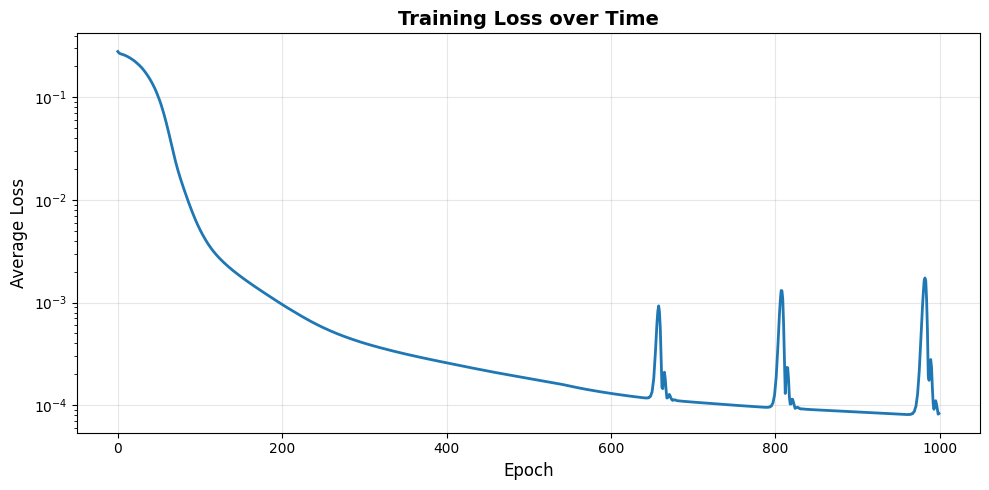

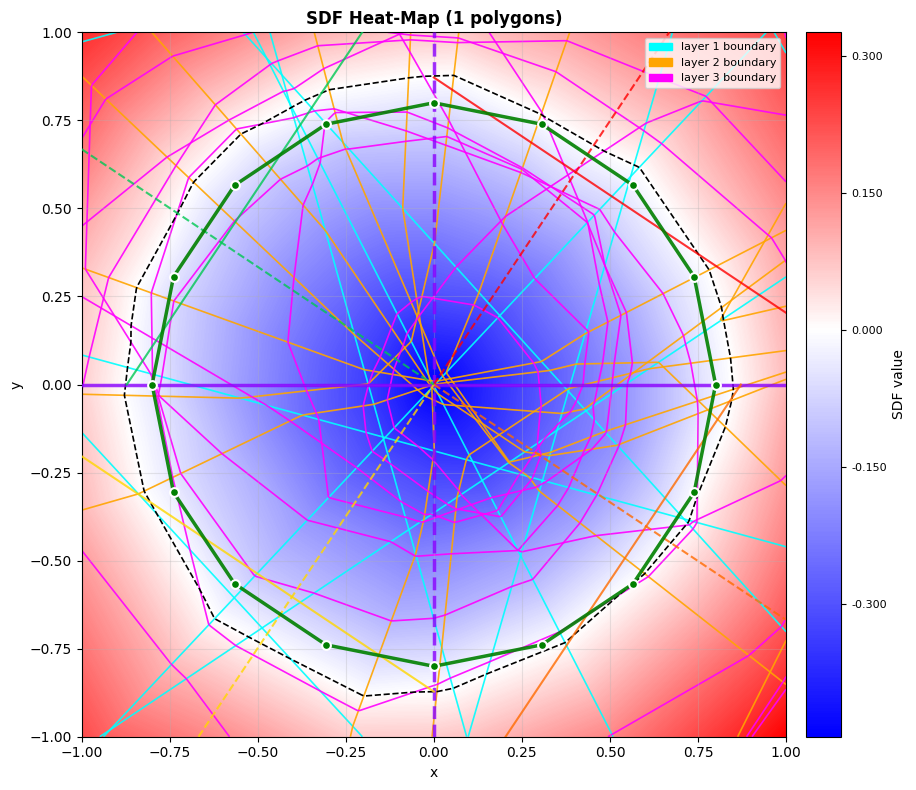

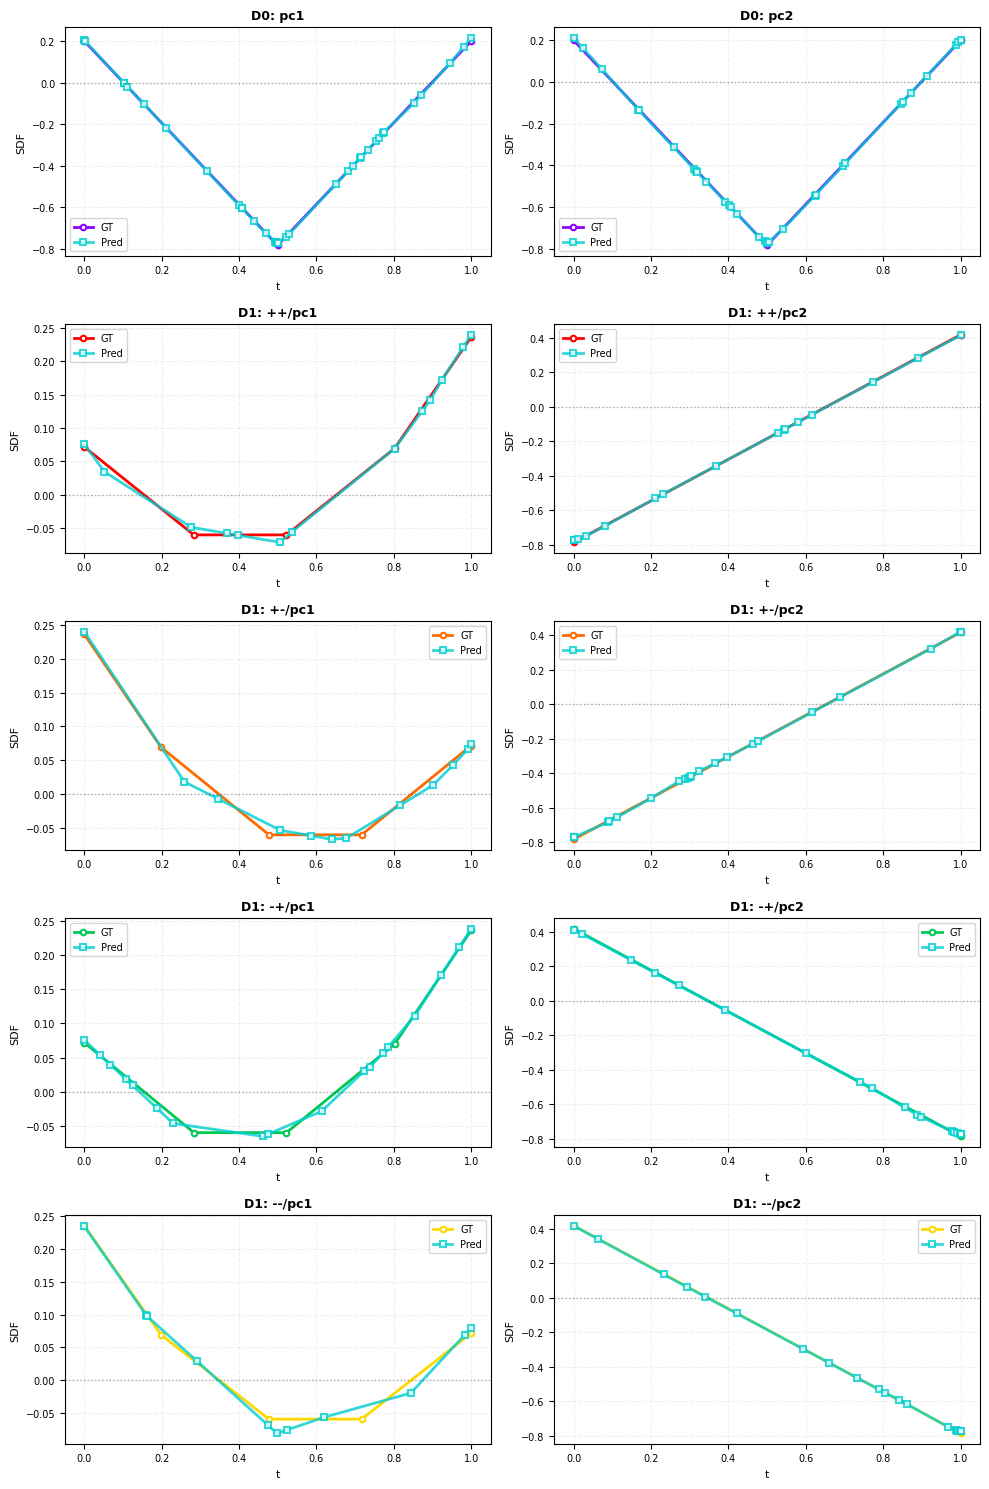

In [115]:
from tqdm import tqdm
from ainr import plot_cell_sdf3
import torch.nn.functional as F

torch.manual_seed(0)

hidden_dim = 16
num_layers = 3
mlp = ReluMLP(2, hidden_dim, num_layers, skip_connections=False)
# plot_cell_sdf(mlp)
# splines is already defined in Cell 8 from all_knots


def reset_predictions(mlp: ReluMLP, splines: List[Spline]):
    for spline in splines:
        W0 = mlp.layers[0].weight
        b0 = mlp.layers[0].bias

        p0 = spline.start_point
        p1 = spline.end_point
        d = p1-p0
        # d = F.normalize(d, dim=0)
        # t_start = p0
        # t_end = p1
        # d = 
        # d = d/F.normalize(d, dim=0)

        alpha = W0 @ d
        beta = W0 @ p0 + b0

        eps_safe = 1e-5
        eps = 1e-8

        t_start = torch.tensor(0.0, dtype=torch.float32)
        t_end = torch.tensor(1.0, dtype=torch.float32)
        valid_mask = torch.abs(alpha)>eps_safe
        t_new = -beta[valid_mask] / alpha[valid_mask]
        mask = (t_new>t_start+eps) & (t_new<t_end-eps)
        t_new = t_new[mask]
        t_new = sort_and_drop_duplicates(t_new)

        if len(t_new) > 0:
            t_knots = torch.cat([t_start.unsqueeze(0), t_new, t_end.unsqueeze(0)])
        else:
            t_knots = torch.stack([t_start, t_end])

        h_values = (alpha.unsqueeze(1)@t_knots.unsqueeze(0)+beta.unsqueeze(1)).T

        for layer in mlp.layers[1:-1]:
            W = layer.weight
            b = layer.bias

            h_values = torch.relu(h_values)
            h_values = (W @ h_values.T).T + b

            t_new = []
            h_new = []
            for t_start, t_end, h_start, h_end in zip(t_knots[:-1], t_knots[1:], h_values[:-1], h_values[1:]):
                t_new.append(t_start.unsqueeze(0))
                h_new.append(h_start.unsqueeze(0))

                # find all flipping h values
                sign_flips = (h_start*h_end) < 0
                flip_idx = torch.where(sign_flips)[0]

                # calculate new t values
                if len(flip_idx)>0:
                    t_cross = t_start - h_start[flip_idx] * (t_end-t_start) / (h_end[flip_idx] - h_start[flip_idx])

                    valid_mask = (t_cross > t_start + eps) & (t_cross < t_end - eps) 
                    t_cross = t_cross[valid_mask]
                    t_cross = sort_and_drop_duplicates(t_cross)

                    if len(t_cross) > 0:
                        alpha_t = (t_cross - t_start) / (t_end - t_start)
                        h_cross = h_start + alpha_t.unsqueeze(1) * (h_end - h_start)

                        t_new.append(t_cross)
                        h_new.append(h_cross)

            t_new.append(t_knots[-1].unsqueeze(0))
            h_new.append(h_values[-1].unsqueeze(0))

            t_knots = torch.cat(t_new)
            if t_knots.requires_grad:
                t_knots.retain_grad()
            h_values = torch.cat(h_new)
            if h_values.requires_grad:
                h_values.retain_grad()

        W = mlp.layers[-1].weight
        b = mlp.layers[-1].bias
        h_values = (W @ h_values.T).T + b
        spline.pred_knots = t_knots
        spline.pred_values = h_values.squeeze(1)


optimizer = optim.Adam(mlp.parameters(), lr=0.001)

batch_size = 4
episodes = 1_000
loss_history = []

pbar = tqdm(range(episodes))
for epoch in pbar:
    # Shuffle spline indices for this epoch
    n_splines = len(splines)
    indices = np.arange(n_splines)
    # np.random.shuffle(indices)
    
    epoch_loss = 0.0
    epoch_batches = 0
    
    # Process splines in batches
    for batch_start in range(0, n_splines, batch_size):
        batch_end = min(batch_start + batch_size, n_splines)
        batch_indices = indices[batch_start:batch_end]
        
        optimizer.zero_grad()
        batch_splines = [splines[i] for i in batch_indices]
        
        # Reset predictions for all splines (needed for network state)
        reset_predictions(mlp, batch_splines)
        
        # Calculate loss only for splines in this batch
        batch_loss = 0
        valid_splines = 0
        for spline in batch_splines:
            if len(spline.pred_knots) > 1:
                # Calculate the Area Between Curves
                loss = calculate_exact_integral_loss(
                    spline.pred_knots, 
                    spline.pred_values,
                    spline.gt_knots, 
                    spline.gt_values
                )
                
                batch_loss += loss
                valid_splines += 1
        
        if valid_splines > 0:
            batch_loss.backward()
            # Clip gradients to max norm of 1.0 or 0.5
            torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0) 
            optimizer.step()
            epoch_loss += batch_loss.item()
            epoch_batches += 1
    
    # Update progress bar with epoch loss
    if epoch_batches > 0:
        avg_epoch_loss = epoch_loss / epoch_batches
        loss_history.append(avg_epoch_loss)
        pbar.set_postfix({'loss': f'{avg_epoch_loss:.6f}'})

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss over Time', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.yscale('log')  # Log scale often helps visualize loss curves
plt.tight_layout()
plt.show()

reset_predictions(mlp, splines)
plot_cell_sdf3(mlp, splines=splines, polygons=polygons)

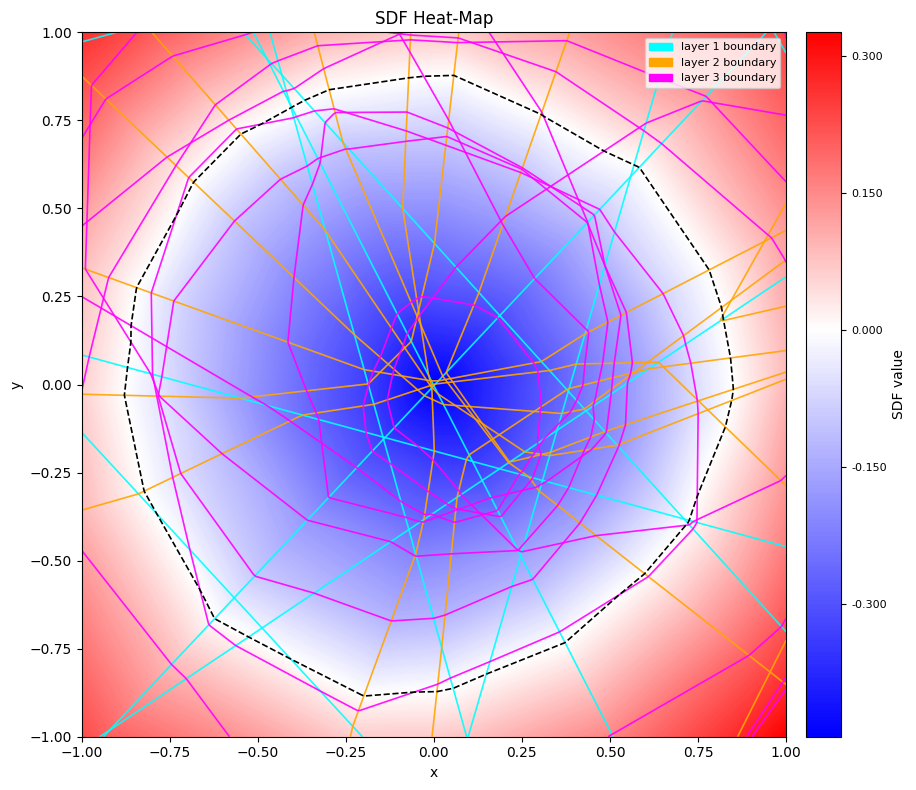

In [116]:
from ainr import plot_cell_sdf2


plot_cell_sdf2(mlp)

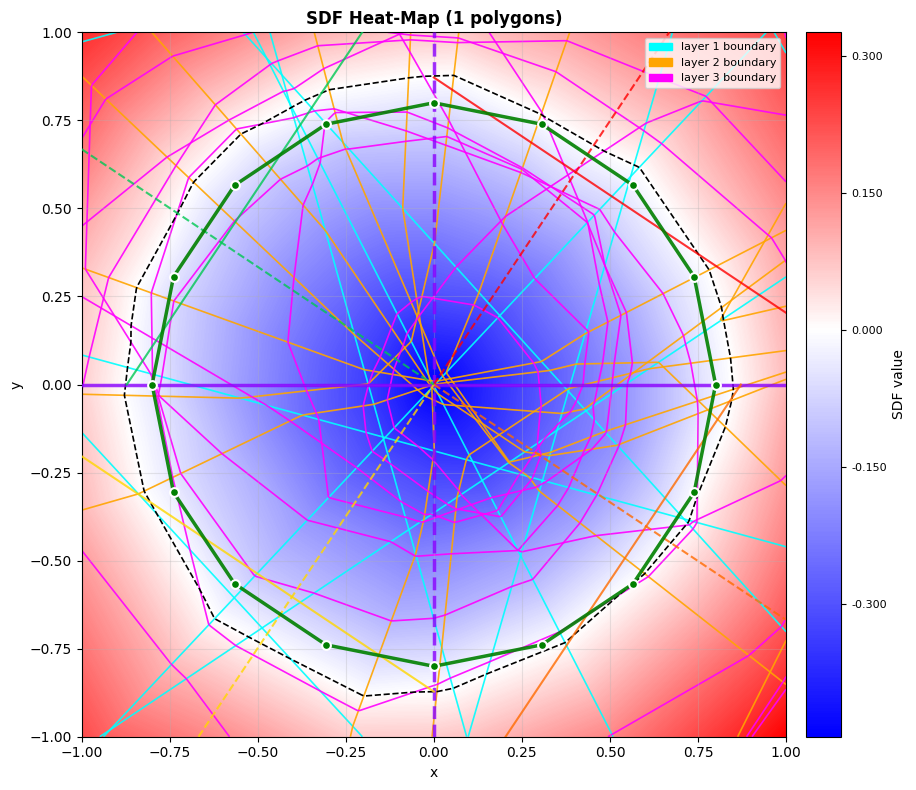

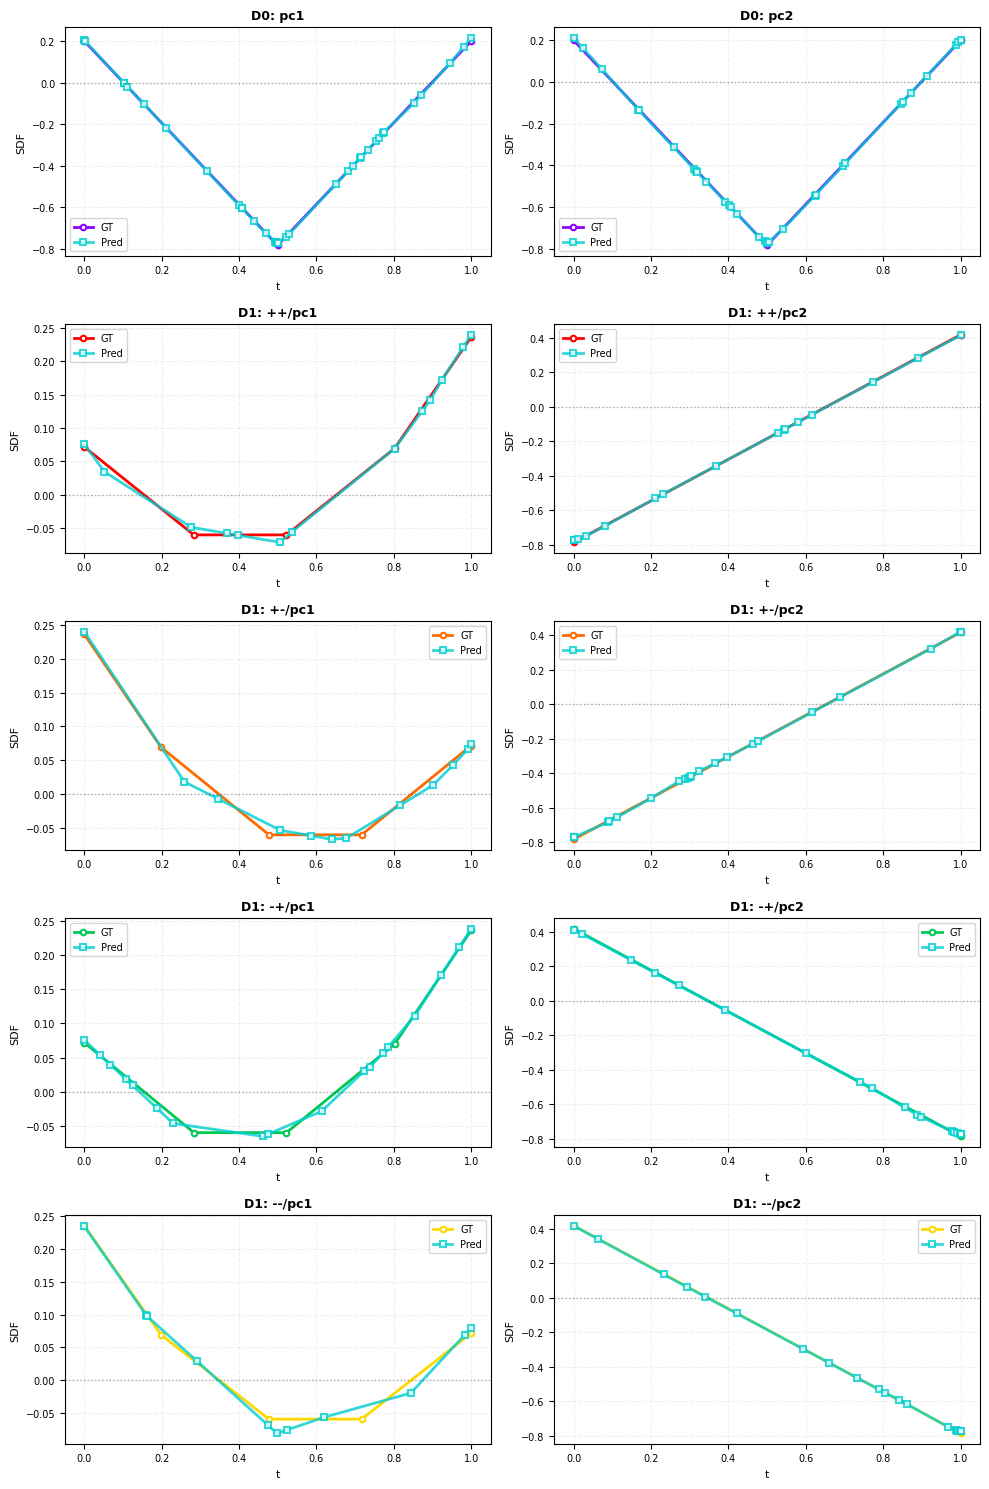

In [117]:
for spline in splines:
    reset_predictions(mlp, splines)
plot_cell_sdf3(mlp, splines=splines, polygons=polygons)

In [118]:
# Import the new refactored functions
from ainr.vis import plot_sdf_heatmap, plot_splines

# Example 1: Plot just the SDF heatmap with polygons and spline lines
plot_sdf_heatmap(mlp, splines=splines, polygons=polygons, interactive=True)

# Example 2: Plot splines separately (PC1 | PC2 per row)
plot_splines(splines, interactive=True)

# Example 3: Interactive versions (requires plotly)
# plot_sdf_heatmap(mlp, splines=splines, polygons=polygons, interactive=True)
# plot_splines(splines, interactive=True)
